## Recruitment Bot sentiment analysis model

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
import string
import re
from string import digits
from cleantext import clean
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
stop_words = set(stopwords.words('english'))

df = pd.read_csv("train_sentiment.csv")

# EDA

In [2]:
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km�),Density (P/Km�)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [3]:
df.columns

Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km�)',
       'Density (P/Km�)'],
      dtype='object')

In [5]:
print(df.shape)

(27481, 10)


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27480 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27480 non-null  object 
 4   Time of Tweet     27480 non-null  object 
 5   Age of User       27480 non-null  object 
 6   Country           27480 non-null  object 
 7   Population -2020  27480 non-null  int64  
 8   Land Area (Km�)   27480 non-null  float64
 9   Density (P/Km�)   27480 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.3+ MB
None


In [8]:
df.dropna(inplace=True)

In [12]:
text_df = df[['text','sentiment']]
print(text_df.shape)
text_df.head(5)

(27480, 2)


,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [32]:
text_df.describe()

,text,sentiment
count,16363,16363
unique,16363,2
top,A very exciting week,positive
freq,1,8582


In [17]:
text_df = text_df[text_df['sentiment'] != 'neutral']
print(text_df.shape)
text_df.head(5)

(16363, 2)


,text,sentiment
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
6,2am feedings for the baby are fun when he is a...,positive


In [18]:
dist = text_df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
dist.style.background_gradient(cmap='RdBu_r')

,sentiment,text
1,positive,8582
0,negative,7781


In [24]:
text_df["sentiment"].value_counts()

positive    8582
negative    7781
Name: sentiment, dtype: int64

# Visualization

In [53]:
text_df['temp_list'] = text_df["text"].apply(lambda x:str(x).split())
top = Counter([item for sublist in text_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,to,5752
1,I,5437
2,the,5059
3,a,4063
4,my,3132
5,and,2964
6,i,2756
7,you,2375
8,is,2310
9,for,2163


<AxesSubplot:xlabel='sentiment', ylabel='count'>

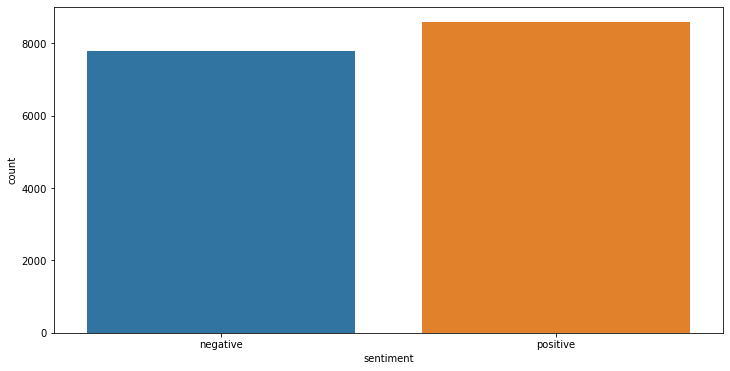

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=text_df)

In [31]:
fig = go.Figure(go.Funnelarea(
    text =dist.sentiment,
    values = dist.text,
    title = {"position": "top center", "text": "Sentiment Distribution"}
    ))
fig.show()

In [55]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [56]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [35]:
sentiment_label = text_df.sentiment.factorize()
sentiment_label

(array([0, 0, 0, ..., 0, 1, 1], dtype=int64),
 Index(['negative', 'positive'], dtype='object'))

In [36]:
text = text_df.text.values

In [37]:
new_text = []
for t in text:
    if type(t) == str:
        t.lower()
    
        # Remove urls from the comments
        t = re.sub(r"http\S+|www\S+|https\S+", '', t, flags=re.MULTILINE)
        # Remove user related references from the comments:: '@' and '#' 
        t = re.sub(r'\@\w+|\#','', t)    
        # Remove punctuations from the comments
        t = t.translate(str.maketrans('', '', string.punctuation))    
        # Remove numbers
        table = str.maketrans('', '', digits)
        t = t.translate(table)
        #Remove emojis
        t = clean(t, no_emoji=True)    
        # Remove stopwords from the comments
        text_tokens = word_tokenize(t)
        filtered_words = [w for w in text_tokens if not w in stop_words]
        joined_text = " ".join(filtered_words)
        new_text.append(joined_text)

In [38]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(new_text)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(new_text)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [39]:
print(tokenizer.word_index)

{'im': 1, 'day': 2, 'good': 3, 'love': 4, 'like': 5, 'happy': 6, 'get': 7, 'dont': 8, 'got': 9, 'go': 10, 'cant': 11, 'today': 12, 'really': 13, 'mothers': 14, 'work': 15, 'going': 16, 'thanks': 17, 'one': 18, 'u': 19, 'time': 20, 'know': 21, 'great': 22, 'lol': 23, 'back': 24, 'much': 25, 'miss': 26, 'night': 27, 'well': 28, 'hope': 29, 'see': 30, 'oh': 31, 'na': 32, 'new': 33, 'think': 34, 'fun': 35, 'still': 36, 'sad': 37, 'feel': 38, 'want': 39, 'home': 40, 'thats': 41, 'wish': 42, 'nice': 43, 'sorry': 44, 'morning': 45, 'bad': 46, 'haha': 47, 'last': 48, 'need': 49, 'would': 50, 'ill': 51, 'tonight': 52, 'better': 53, 'twitter': 54, 'tomorrow': 55, 'right': 56, 'awesome': 57, 'gon': 58, 'hate': 59, 'make': 60, 'didnt': 61, 'sleep': 62, 'thank': 63, 'best': 64, 'weekend': 65, 'could': 66, 'though': 67, 'week': 68, 'youre': 69, 'getting': 70, 'way': 71, 'come': 72, 'ive': 73, 'people': 74, 'yeah': 75, 'bed': 76, 'sick': 77, 'feeling': 78, 'wait': 79, 'even': 80, 'mom': 81, 'next': 8

In [40]:
print(text[0])
print(encoded_docs[0])

 Sooo SAD I will miss you here in San Diego!!!
[252, 37, 26, 1270, 2211]


In [41]:
print(padded_sequence[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  252
   37 

In [42]:
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           604896    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 621,547
Trainable params: 621,547
Non-trainable params: 0
__________________________________________________

In [43]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
410/410 [==============================] - 67s 148ms/step - loss: 0.5174 - accuracy: 0.7332 - val_loss: 0.3649 - val_accuracy: 0.8524
Epoch 2/5
410/410 [==============================] - 59s 145ms/step - loss: 0.3168 - accuracy: 0.8712 - val_loss: 0.3273 - val_accuracy: 0.8631
Epoch 3/5
410/410 [==============================] - 59s 145ms/step - loss: 0.2601 - accuracy: 0.8953 - val_loss: 0.3315 - val_accuracy: 0.8640
Epoch 4/5
410/410 [==============================] - 62s 151ms/step - loss: 0.2312 - accuracy: 0.9089 - val_loss: 0.3437 - val_accuracy: 0.8512
Epoch 5/5
410/410 [==============================] - 60s 147ms/step - loss: 0.2088 - accuracy: 0.9178 - val_loss: 0.3603 - val_accuracy: 0.8494


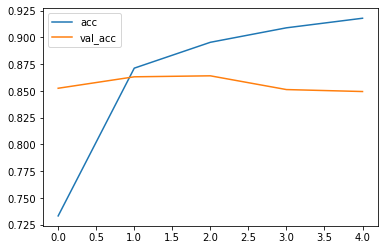

<Figure size 432x288 with 0 Axes>

In [44]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

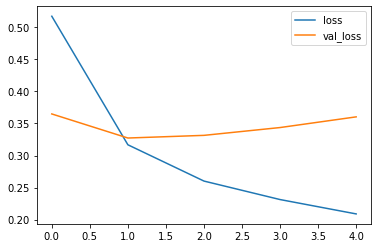

<Figure size 432x288 with 0 Axes>

In [45]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [59]:
np.max(history.history['accuracy'])

0.9177998304367065

In [46]:
def predict_sentiment(texts):
    tw = tokenizer.texts_to_sequences([texts])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print(prediction)
    print("Predicted label: ", sentiment_label[1][prediction])

In [47]:
sentiment_label[1][1]

'positive'

In [48]:
test_sentence1 = "The bot was good."
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

1/1 [==============================] - 4s 4s/step
1
Predicted label:  positive
1/1 [==============================] - 2s 2s/step
0
Predicted label:  negative
